<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/BME511/BME511_PS4_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BME 511 Fall 2021 -- Problem Set 4 Solutions

## Q1

Problem 1 is just the project proposal.

## Q2

### Primary utility of tapering in the construction of spectrum estimates

When constructing spectral estimates using the periodogram, the finite duration of measurements translates to biased estimates where the bias comes from the frequency-smoothing properties of the "default" rectangular window of measurement. The rectangular window has the sinc function as its Fourier transform, which has slowly decaying side lobes. Thus, the spectral smoothing bias can leak the energy at any given frequency to far-away freqyency bins. This leakage is reduced by explicitly applying window shapes (i.e., tapers) with smaller side lobes in the Fourier domain.

### Welch method, and the main trade offs involved in constructing spectrum estimates using the Welch method

To reduce the variance in the spectral estimates, the Welch method divides any given measurement into smaller segments (of shorter duration), and then averages the spectrum estimates obtained from each segment. However, because each segment is shorter, bias is introduced owing to the frequency-smoothing of the resulting shorter window. This leads to both poorer spectral resolutions and higher leakage.

## Q3

### Q3(a) Creating a quadratic chirp

In [1]:
import numpy as np
import pylab as pl

# Setting it so figs will be a bit bigger
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.33]
plt.rcParams['figure.dpi']  = 120

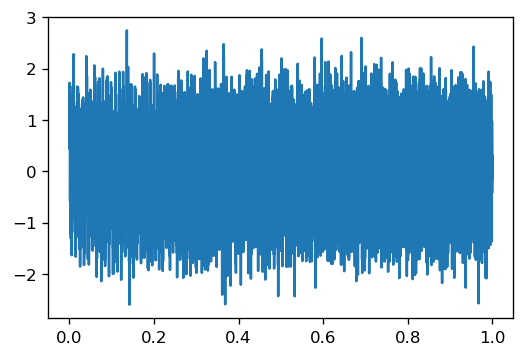

In [2]:
fs = 10000
t = np.arange(0, 1., 1/fs)
phi = 2 * np.pi * (100 * t + (400./3) * (t ** 3))
x = np.cos(phi) + np.random.randn(t.shape[0])*0.5
pl.plot(t, x)

### Q3(b) Periodogram and multitaper estimates (treating the chirp as stationary) 

(0.0, 1000.0)

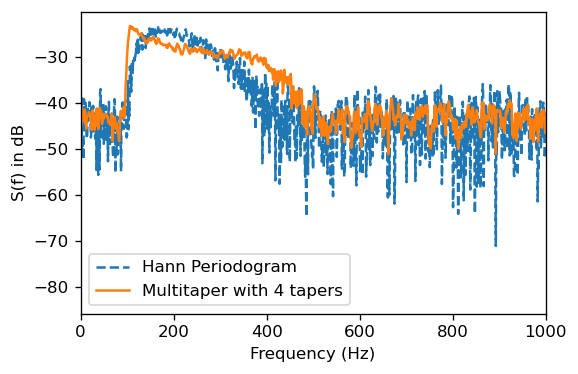

In [3]:
from scipy import signal

# Periodogram using the Hann window (no specific taper was requested)
f_periodogram, S_periodogram = signal.periodogram(x, window='hann', fs=fs)


# Multitaper estimate with 4 tapers requested, so (2*NW - 1) has to be at least 4
NW = 3   
Kmax = 4

# Return concentrations too using return_ratios=True
N = t.shape[0]
wins, concentrations = signal.windows.dpss(N, NW, Kmax=Kmax, return_ratios=True)
S_mt = 0
for ktap in range(Kmax):
    f_mt, S_temp = signal.periodogram(x, window=wins[ktap, :], fs=fs)
    S_mt += S_temp 
S_mt /= Kmax

pl.plot(f_periodogram, 10*np.log10(S_periodogram), '--')
pl.plot(f_mt, 10*np.log10(S_mt))

pl.xlabel('Frequency (Hz)')
pl.ylabel('S(f) in dB')
pl.legend(('Hann Periodogram', 'Multitaper with 4 tapers'))
pl.xlim([0, 1000])

From the above plots, we can see that the multitaper method produces a lower-variance estimate.

### Q3(c) Time-reversed chirp

(0.0, 1000.0)

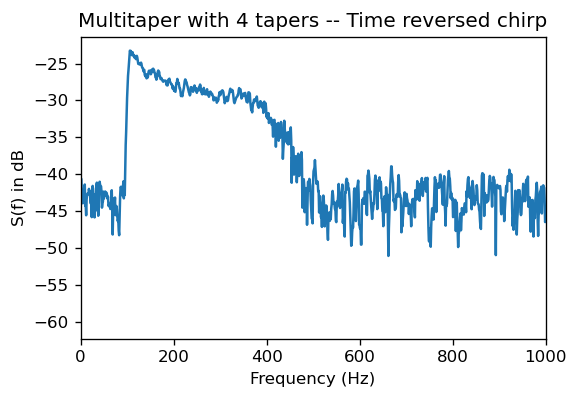

In [4]:
xrev = x[::-1]

S_mt_rev = 0
for ktap in range(Kmax):
    f_mt, S_temp = signal.periodogram(x, window=wins[ktap, :], fs=fs)
    S_mt_rev += S_temp 
S_mt_rev /= Kmax

pl.plot(f_mt, 10*np.log10(S_mt_rev))

pl.xlabel('Frequency (Hz)')
pl.ylabel('S(f) in dB')
pl.title('Multitaper with 4 tapers -- Time reversed chirp')
pl.xlim([0, 1000])

Given that spectral estimates have no time resolution, the spectra cannot distinguish between forward and time-reversed chirps!

### Q3(d) Spectrogram with single DPSS taper at 100 ms windows

Data is 1 trials and 1 channels
Multitaper time-frequency analysis for 150 frequencies
Using 1 tapers


Text(0, 0.5, 'Frequency (Hz)')

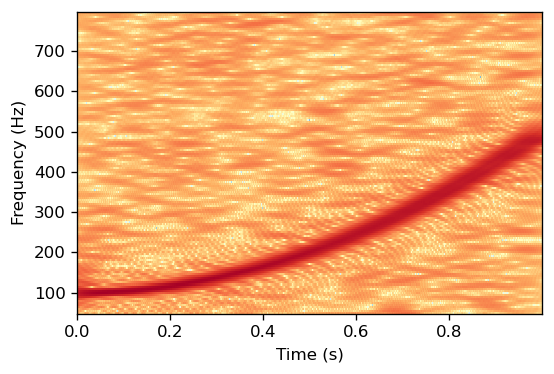

In [5]:
import tfr

freqs = np.arange(50, 800, 5)
n_cycles = freqs * 0.1  # Makes the window length 100 ms

S, times = tfr.tfr_multitaper(x[None,None, :], fs, frequencies=freqs, n_cycles=n_cycles, time_bandwidth=2)


pl.pcolormesh(t, freqs, 10*np.log10(S.squeeze()), cmap='RdYlBu_r', shading='auto')
pl.xlabel('Time (s)')
pl.ylabel('Frequency (Hz)')


Repeat for time-reversed chirp

Data is 1 trials and 1 channels
Multitaper time-frequency analysis for 150 frequencies
Using 1 tapers


Text(0, 0.5, 'Frequency (Hz)')

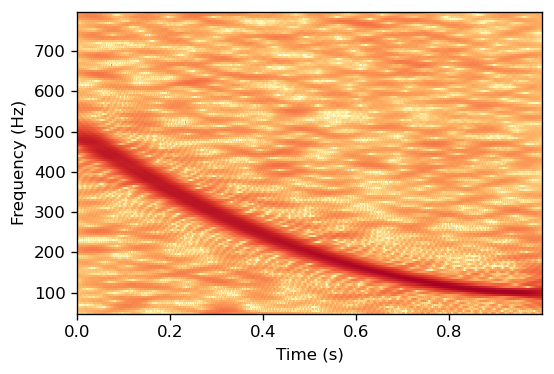

In [6]:
S_rev, times = tfr.tfr_multitaper(xrev[None,None, :], fs, frequencies=freqs, n_cycles=n_cycles, time_bandwidth=2)


pl.pcolormesh(t, freqs, 10*np.log10(S_rev.squeeze()), cmap='RdYlBu_r', shading='auto')
pl.xlabel('Time (s)')
pl.ylabel('Frequency (Hz)')

The fact that the chirp pattern is reversed (i.e., high-to-low sweeping of frequency as opposed to low-to-high) is clear in the spectrograms.

### Q3(e) Multitaper spectrogram with 4 tapers

Need to only change the time-bandwidth product to get more usable tapers. Note that in the ```tfr``` library, the ```time_bandwidth``` parameter is 2NW instead of NW.

Data is 1 trials and 1 channels
Multitaper time-frequency analysis for 150 frequencies
Using 4 tapers


Text(0, 0.5, 'Frequency (Hz)')

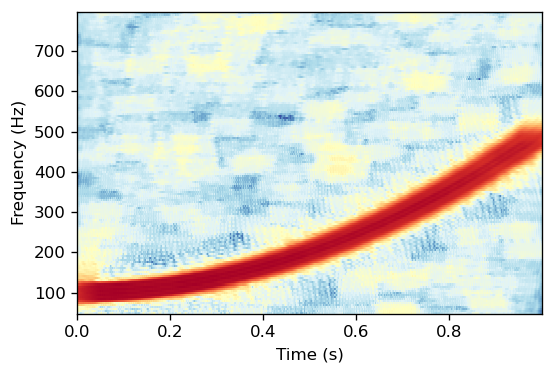

In [7]:
S, times = tfr.tfr_multitaper(x[None,None, :], fs, frequencies=freqs, n_cycles=n_cycles, time_bandwidth=5)


pl.pcolormesh(t, freqs, 10*np.log10(S.squeeze()), cmap='RdYlBu_r', shading='auto')
pl.xlabel('Time (s)')
pl.ylabel('Frequency (Hz)')

Compared to the spectrograms from a single taper, it's clear that the variance is lower, but that frequency resolution is wider (poorer).

## Q4:  Wavelet spectrograms and /ba/ - /da/ differences

In [8]:
from scipy import io
dat = io.loadmat('speech.mat', squeeze_me=True)

In [9]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ba', 'da', 'fs'])

### Q4(a) Spectrograms with 9-cycle wavelets, 20 frequency bins per octave, and single-DPSS tapers

Data is 1 trials and 1 channels
Multitaper time-frequency analysis for 120 frequencies
Using 1 tapers


Text(0, 0.5, 'Frequency (Hz)')

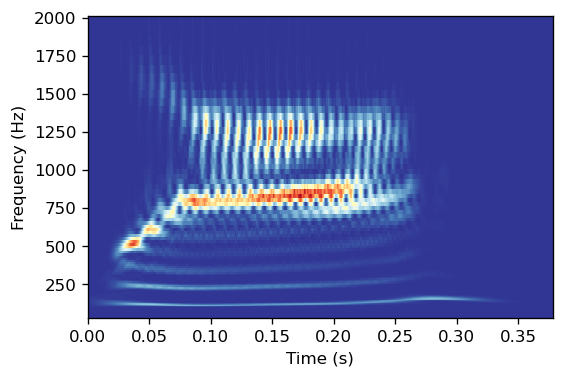

In [10]:
freqs = 2 ** np.arange(5, 11, 1./20)
n_cycles = 9

S, times = tfr.tfr_multitaper(dat['da'][None,None, :], dat['fs'],
                              frequencies=freqs, n_cycles=n_cycles, time_bandwidth=2)

pl.pcolormesh(times, freqs, S.squeeze(), cmap='RdYlBu_r', shading='auto')
pl.xlabel('Time (s)')
pl.ylabel('Frequency (Hz)')


Data is 1 trials and 1 channels
Multitaper time-frequency analysis for 120 frequencies
Using 1 tapers


Text(0, 0.5, 'Frequency (Hz)')

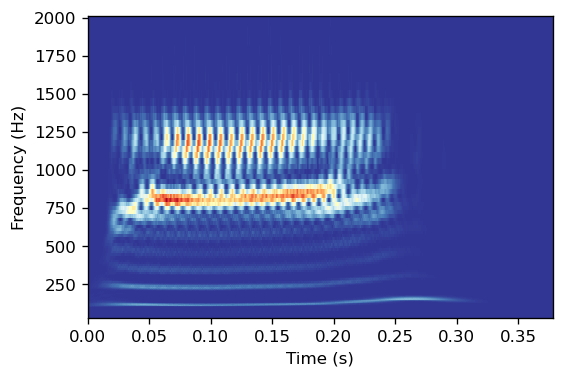

In [11]:
S, times = tfr.tfr_multitaper(dat['ba'][None,None, :], dat['fs'],
                              frequencies=freqs, n_cycles=n_cycles, time_bandwidth=2)

pl.pcolormesh(times, freqs, S.squeeze(), cmap='RdYlBu_r', shading='auto')
pl.xlabel('Time (s)')
pl.ylabel('Frequency (Hz)')

The transition in the formants before landing on the /a/ vowel is distinct between the /ba/ and /da/ syllables. With the /da/ sound, it is clear that there lower formant starts from a much lower frequency, whereas the higher formant starts from a much higher frequency. With /ba/ the excursions are short!

## Q5 Audio compression

First let's start by playing the audio. Then we'll explore compression as requested.

In [12]:
from IPython.display import Audio
Audio(data=dat['ba'], rate=dat['fs'])

In [13]:
Audio(data=dat['da'], rate=dat['fs'])

### Q5(a, b, c) Removing coefficients and reconstructing using a 5-level ```coif3``` decomposition

For this we will iteratively change the threshold until the desired % of the coefficients are removed.


(a) A threshold of 0.0005 seems to give 66% reduction. With 66% compression, there is no obvious change is audio quality. More careful perceptual experiments are needed to see if they are really indistinguishable, but based on simply listening, for me they are indistinguishable.

(b) I am able to distinguish the compressed and original when the threshold is abou 0.02, which corresponds to only keeping 8% of the coefficients.

(c) I am starting to confuse /ba/ and /da/ when the thheshold is about 0.15, which corresponds to only keeping 1.8% of the coefficients

In [14]:
import pywt
coeffs = pywt.wavedec(dat['ba'],wavelet='coif3', level=5)

# Convert to array -- easier for thresholding
arr, slices = pywt.coeffs_to_array(coeffs)
ncoeffs = arr.shape[0]

thresh = 0.15  # Changing this to obtained desired compression level
arr[abs(arr) < thresh] = 0
arr[arr > thresh] -= thresh
arr[arr < -thresh] += thresh
ncoeffs_compressed = (abs(arr) > thresh).sum()
print(f'Compressed size = {ncoeffs_compressed * 100./ ncoeffs: .1f}% of original size')

# Convert back to wavedec/waverec format
coeffs_compressed = pywt.array_to_coeffs(arr, slices, output_format='wavedec')
compressed = pywt.waverec(coeffs_compressed, wavelet='coif3')
Audio(data=compressed, rate=dat['fs'])

Compressed size =  1.8% of original size


## Q6: Image compression and "sharpening"

Text(0.5, 1.0, 'Original')

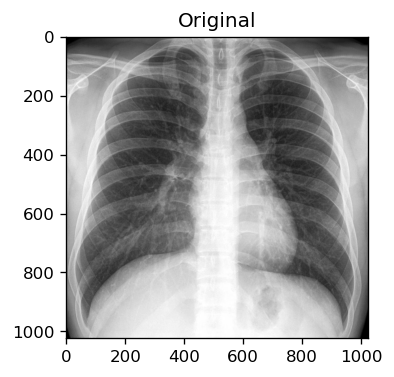

In [15]:
dat = io.loadmat('chestradiograph.mat', squeeze_me=True)
J = np.float64(dat['I'])/255.
pl.imshow(J, cmap='gray', vmin=0, vmax=1)
pl.title('Original')

### Q6(a) Using ```db2``` wavelets for compression

Compressed size =  5.2% of original size


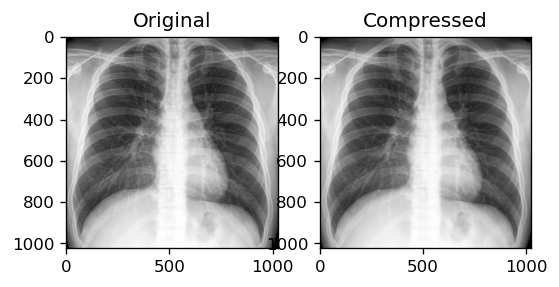

In [16]:
coeffs = pywt.wavedec2(J, wavelet='db2', level=6)

# Convert to array -- easier for thresholding
arr, slices = pywt.coeffs_to_array(coeffs)
ncoeffs = (abs(arr) > 0).sum()

thresh = 0.02
arr[abs(arr) < thresh] = 0
arr[arr > thresh] -= thresh
arr[arr < -thresh] += thresh
ncoeffs_compressed = (abs(arr) > thresh).sum()

# Convert back to wavedec/waverec format
coeffs_compressed = pywt.array_to_coeffs(arr, slices, output_format='wavedec2')
compressed = pywt.waverec2(coeffs_compressed, wavelet='db2')

pl.subplot(121)
pl.imshow(J, cmap='gray', vmin=0, vmax=1)
pl.title('Original')
pl.subplot(122)
pl.imshow(compressed, cmap='gray', vmin=0, vmax=1)
pl.title('Compressed')
print(f'Compressed size = {ncoeffs_compressed * 100./ ncoeffs: .1f}% of original size')


While there are no obvious gross differences, the 5% image appears somewhat smoother.

### Q6(b) Using a 3 x 3 convolution kernel for sharpening

Text(0.5, 1.0, 'Compressed and Sharpened')

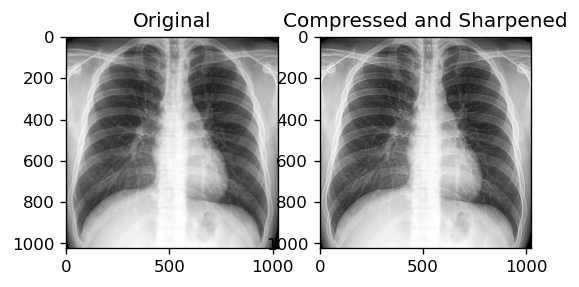

In [17]:
# Sharpen
from scipy import ndimage as img
h = np.asarray([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
compressed_sharp = img.convolve(compressed, h, mode='nearest')

pl.subplot(121)
pl.imshow(J, cmap='gray', vmin=0, vmax=1)
pl.title('Original')
pl.subplot(122)
pl.imshow(compressed_sharp, cmap='gray', vmin=0, vmax=1)
pl.title('Compressed and Sharpened')

From basic visual inspection, the compressed and sharpened image appears to retain all key features of the original image, and perhaps even enhances the contrast of structures relative to the original. Thus, this is a promising approach to address the compression needs for this application.